In [1]:
import os
from pathlib import Path

In [83]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
EXP_DIR = Path("exp/baseline_1")
EXP_DIR.mkdir(exist_ok=False, parents=True)

In [2]:
import torch
import torch.nn as nn
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as utils_data
from typing import List, Union, Set
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
from dataclasses import dataclass
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import editdistance
import pickle

%matplotlib inline

In [3]:
class TextEncoder:
    def __init__(self, allowed_chars: Set[str]):
        self.allowed_chars = allowed_chars
        self.id2char = ["<blank>"] + sorted(allowed_chars)
        self.char2id = dict(zip(self.id2char, range(len(self.id2char))))
        
    def encode(self, text: str):
        return [self.char2id[c] for c in text]

    def decode(self, sequence: List[int]):
        return "".join(self.id2char[i] for i in sequence)
    
    def decode_ctc(self, sequence: List[int]):
        return "".join(self.id2char[i] for i, _ in itertools.groupby(sequence) if i != 0)

In [4]:
english = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'm', 'n' ,'o', 'p', 'r', 's', 't', 'u', 'w'}
with open("data/chars_set.pkl", "rb") as f:
    all_chars = pickle.load(f)
encoder = TextEncoder(all_chars - english)

In [5]:
def process_image(img):
    w, h,_ = img.shape
    
    new_w = 128
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h,_ = img.shape
    
    img = img.astype('float32')
    
    if w < 128:
        add_zeros = np.full((128-w, h,3), 255)
        img = np.concatenate((img, add_zeros))
        w, h,_ = img.shape
    
    if h < 1024:
        add_zeros = np.full((w, 1024-h,3), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h,_ = img.shape
        
    if h > 1024 or w > 128:
        dim = (1024,128)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)

    img = img / 255
    
    return img

In [6]:
with open("data/train_uttids_set.pkl", "rb") as f:
    train_uttids = pickle.load(f)
with open("data/val_uttids_set.pkl", "rb") as f:
    val_uttids = pickle.load(f)

In [7]:
class DigitalPeterDataset(Dataset):
    def __init__(self, base_dir: Union[Path, str], uttids: Set[str]):
        super().__init__()
        base_dir = Path(base_dir)
        self.trans_dir = base_dir / "words"
        self.image_dir = base_dir / "images"
        self.images = []
        self.texts = []
        self.encoded_texts = []
        self.keys = []
#         self.chars_counter = Counter()
        self.encoder = encoder

        for imagepath in tqdm(self.image_dir.glob("*.jpg")):
            key = imagepath.stem
            if key not in uttids:
                continue
            textpath = self.trans_dir / f"{key}.txt"
            with open(textpath, "r", encoding="utf-8") as f:
                text = f.read().strip()
            if not text:
                print(imagepath, textpath, text)
                continue
            if len(set(text).intersection(english)) > 0:
                print(f"skipping {key}: {text}")
                continue
#             self.all_chars.update(text)
#             self.chars_counter.update(text)
            self.keys.append(key)
            self.texts.append(text)
            img = cv2.imread(f"{imagepath}")
            img = process_image(img)
            self.images.append(torch.FloatTensor(img.transpose(2, 0, 1))) # HxWxC -> CxHxW
        for text in self.texts:
            self.encoded_texts.append(self.encoder.encode(text))
    
    def __getitem__(self, index):
        return self.images[index], self.texts[index], self.encoded_texts[index], len(self.texts[index])
    
    def __len__(self):
        return len(self.texts)

In [8]:
train_data = DigitalPeterDataset("data/train", train_uttids)
val_data = DigitalPeterDataset("data/train", val_uttids)

skipping 209_31_12: d другой столбъ с короною явъляюшей
skipping 19_5_0: min her +
skipping 215_38_10: а в точку f iз которой протчия линеi дѣлай
skipping 217_40_19: бери дистанциi на линii e f гдѣ доткнулис линѣ
skipping 163_7_0: sire
skipping 163_4_4: iз санктъпитербурха въ 27 д генваря piter
skipping 217_40_11: казывает в обѣiх углах d] аш] потом
skipping 133_36_0: mrsi
skipping 217_40_14: e f потом iз точки  g начерти полкруга
skipping 188_4_14: мушкѣтная стрелба h какъ все то
skipping 182_4_6: пушки стала а реданы при b bd дѣат
skipping 14_29_10: р s карабль наш сваятого петра сего
skipping 109_7_1: cну i осмотря все быт с полным до
skipping 217_40_21: черчивай паралелныя линѣi гдѣ линѣя a g
skipping 356_4_4: iз лагара въ 27 д iюня piter
skipping 188_4_21: aa
skipping 163_6_4: p s
skipping 17_7_10: р s поздравляем сим днем
skipping 22_11_13: piter
skipping 164_13_0: sire
skipping 337_41_2: гиc областей что
skipping 163_6_0: siire
skipping 217_40_15: h i i раздели [с которой кругом

skipping 425_37_0: p s також донеси i то к в
skipping 214_37_23: ⊕ iз точки f



In [9]:
len(train_data), len(val_data)

(5693, 412)

In [10]:
max_text_len = 0
for text in itertools.chain(train_data.texts, val_data.texts):
    max_text_len = max(max_text_len, len(text))

In [11]:
max_text_len

71

In [12]:
num_outputs = len(train_data.encoder.id2char)
print(num_outputs)

61


In [13]:
for i, encoded_text in enumerate(train_data.encoded_texts):
    train_data.encoded_texts[i] = encoded_text + [num_outputs for _ in range(max_text_len - len(encoded_text))]
for i, encoded_text in enumerate(val_data.encoded_texts):
    val_data.encoded_texts[i] = encoded_text + [num_outputs for _ in range(max_text_len - len(encoded_text))]

In [14]:
# num_samples = len(full_data)
# val_samples = num_samples // 15
# train_data, val_data = utils_data.random_split(full_data, [num_samples - val_samples, val_samples], 
#                                                generator=torch.Generator().manual_seed(666))

In [15]:
len(train_data), len(val_data)

(5693, 412)

In [16]:
def collate_fn(items):
    images = torch.stack([item[0] for item in items])
    encoded_texts = torch.tensor([item[2] for item in items])
    texts = [item[1] for item in items]
    text_lengths = torch.tensor([item[3] for item in items])
    return images, texts, encoded_texts, text_lengths

In [17]:
train_loader = DataLoader(train_data, batch_size=20, shuffle=True, collate_fn=collate_fn)

In [18]:
val_loader = DataLoader(val_data, batch_size=20, shuffle=False, collate_fn=collate_fn)

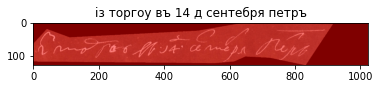

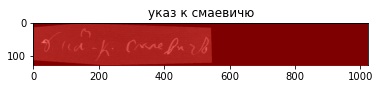

In [19]:
for i in np.random.choice(range(len(train_data)),2):
    img, text, encoded_text, _ = train_data[i]
    plt.imshow((img.numpy().transpose(1, 2, 0) + 1) / 2)
    plt.plot()
    plt.title(text)
    plt.show()

In [20]:
class BaselineModel(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        #input: Bx3x128,1024
        self.encoder = nn.Sequential(*[
            nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=2),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=2),
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.ReLU(), 
            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.ConstantPad2d([0, 0, 2, 1], 0.0), # same padding for maxpool2d
            nn.MaxPool2d(kernel_size=(4, 1), padding=0), # pool_4
            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.ReLU(), 
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ConstantPad2d([0, 0, 1, 2], 0.0), # same padding for maxpool2d
            nn.MaxPool2d(kernel_size=(4, 1), padding=0), 
            nn.Conv2d(512, 512, (2, 2)), # 512x1x255 CxHxW
            nn.ReLU(),
        ])
        
        self.rnn = nn.Sequential(*[
            nn.Dropout(0.2),
            nn.GRU(input_size=512, hidden_size=256, bidirectional=True, dropout=0.2, batch_first=True, num_layers=2)
        ])
        self.final = nn.Linear(512, num_outputs)
    
    def forward(self, x):
        output = self.encoder(x) # Bx512x1x255
        output = output.squeeze(dim=2).transpose(1, 2) # BxLxC
        output = self.rnn(output)[0]
        logits = self.final(output)
        return logits

In [21]:
model = BaselineModel(num_outputs=num_outputs)

In [22]:
# from torchsummary import summary
# summary(model, input_size=(3, 128, 1024), device="cpu")

In [23]:
model(torch.rand(1, 3, 128, 1024)).shape

torch.Size([1, 255, 61])

In [24]:
criterion = nn.CTCLoss(blank=0, reduction="none")

In [25]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [26]:
model.cuda(0)

BaselineModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): ConstantPad2d(padding=[0, 0, 2, 1], value=0.0)
    (11): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [27]:
def train_model():
    model.train()
    for batch_idx, (images, _, targets, target_lengths) in enumerate(tqdm(train_loader)):
        images, targets, target_lengths = images.cuda(), targets.to(torch.int32).cuda(), target_lengths.to(torch.int32).cuda()
        optimizer.zero_grad()
        logits = model(images).transpose(0, 1)
        loss = criterion(F.log_softmax(logits, dim=-1), targets, torch.ones_like(target_lengths) * 255, target_lengths).mean()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"loss: {loss.item():.5f}")

In [28]:
def val_model():
    model.eval()
    num_items = 0
    loss_accum = 0.0
    total_chars = 0
    error_chars = 0
    total_words = 0
    error_words = 0
    with torch.no_grad():    
        for batch_idx, (images, texts, targets, target_lengths) in enumerate(tqdm(val_loader)):
            images, targets, target_lengths = images.cuda(), targets.to(torch.int32).cuda(), target_lengths.to(torch.int32).cuda()
            logits = model(images).transpose(0, 1) # LxBxT
            loss = criterion(F.log_softmax(logits, dim=-1), targets, torch.ones_like(target_lengths) * 255, target_lengths)
            loss_accum += loss.sum().item()
            num_items += len(texts)
            labels = logits.argmax(dim=-1).detach().cpu().numpy().transpose(1, 0)
            for i, encoded_text in enumerate(labels):
                ref = texts[i]
                total_chars += len(ref)
                hyp = encoder.decode_ctc(encoded_text.tolist())
                error_chars += editdistance.eval(hyp, ref)
                total_words += len(ref.split())
                error_words += editdistance.eval(hyp.split(), ref.split())
                if batch_idx == 0:
                    print(f"ref: {ref}")
                    print(f"hyp: {hyp}")
            
            
    loss_accum /= num_items
    print(f"loss: {loss_accum:.5f}")
    print(f"CER: {error_chars / total_chars * 100:.2f}%, WER: {error_words / total_words * 100:.2f}%")
    return loss_accum

In [29]:
reduce_lr = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-5, verbose=True)

In [30]:
num_epochs = 300
best_loss = float("infinity")
prev_loss = float("infinity")
cur_loss = float("infinity")
lr = 1e-4
num_epochs_not_improved = 0
for i_epoch in range(num_epochs):
    print("=" * 50)
    print(f"epoch: {i_epoch + 1}")
    train_model()
    prev_loss = cur_loss
    cur_loss = val_model()
    reduce_lr.step(cur_loss)
    if best_loss < cur_loss:
        num_epochs_not_improved += 1
        print("not improved")
        torch.save(model.state_dict(), EXP_DIR / "model_last.pt")
    else:
        num_epochs_not_improved = 0
        best_loss = cur_loss
        torch.save(model.state_dict(), EXP_DIR / "model_best.pt")
        
    print(f"loss: best {best_loss:.5f} | cur {cur_loss:.5f}")
    if num_epochs_not_improved > 10:
        break

epoch: 1


loss: 918.61859
loss: 92.40459
loss: 96.50011



ref: + но хорошо мужикоф содержите
hyp: 
ref: i тако пѣхота далее
hyp: 
ref: римут то б хотя шквадру от 7
hyp: 
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: 
ref: чтоб мнѣ мое писмо поттвердит
hyp: 
ref: жанъ i лутче всякому своей
hyp: 
ref: зит
hyp: 
ref: пѣхотою удержат
hyp: 
ref: нам здес зело докучает аднакож для
hyp: 
ref: ет указ не описываяс всту
hyp: 
ref: ного и возна в заключе
hyp: 
ref: и протчег
hyp: 
ref: 1
hyp: 
ref: хотя за далностию i непърестаными отмѣ
hyp: 
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: 
ref: государственных дѣл положит на въ
hyp: 
ref: заранѣе
hyp: 
ref: чтоб нашим людем на островѣ не ос
hyp: 
ref: что мы которой мир i отдачю турком обѣ
hyp: 
ref: долго войскъ держат не можем но
hyp: 

loss: 89.03322
CER: 100.00%, WER: 100.00%
loss: best 89.03322 | cur 89.03322
epoch: 2


loss: 94.01183
loss: 94.62207
loss: 80.00114



ref: + но хорошо мужикоф содержите
hyp: 
ref: i тако пѣхота далее
hyp: 
ref: римут то б хотя шквадру от 7
hyp: 
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: 
ref: чтоб мнѣ мое писмо поттвердит
hyp: 
ref: жанъ i лутче всякому своей
hyp: 
ref: зит
hyp: 
ref: пѣхотою удержат
hyp: п
ref: нам здес зело докучает аднакож для
hyp: 
ref: ет указ не описываяс всту
hyp: 
ref: ного и возна в заключе
hyp: 
ref: и протчег
hyp: 
ref: 1
hyp: 
ref: хотя за далностию i непърестаными отмѣ
hyp: 
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: 
ref: государственных дѣл положит на въ
hyp: 
ref: заранѣе
hyp: 
ref: чтоб нашим людем на островѣ не ос
hyp: 
ref: что мы которой мир i отдачю турком обѣ
hyp: 
ref: долго войскъ держат не можем но
hyp: п

loss: 85.45882
CER: 99.70%, WER: 100.00%
loss: best 85.45882 | cur 85.45882
epoch: 3


loss: 91.30945
loss: 89.61847
loss: 59.89921



ref: + но хорошо мужикоф содержите
hyp: з
ref: i тако пѣхота далее
hyp: тако гѣсатал
ref: римут то б хотя шквадру от 7
hyp: рилуттоотя нквадуот
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: ылнурагъ пи кетъ iтого
ref: чтоб мнѣ мое писмо поттвердит
hyp: отанмелнмо отквот
ref: жанъ i лутче всякому своей
hyp: лъ iлутсяколу свые
ref: зит
hyp: ат
ref: пѣхотою удержат
hyp: пъяотогудст
ref: нам здес зело докучает аднакож для
hyp: на чдеело кетнекодлл
ref: ет указ не описываяс всту
hyp: ку коанео пингагт
ref: ного и возна в заключе
hyp: ного вонаъзапяче
ref: и протчег
hyp: i прк
ref: 1
hyp: 
ref: хотя за далностию i непърестаными отмѣ
hyp: пота зода носно iноворостыыни олг
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: орлыво чуя съюдыприѣлоогчаао
ref: государственных дѣл положит на въ
hyp: погротоенноду полоклъ
ref: заранѣе
hyp: заралуѣе
ref: чтоб нашим людем на островѣ не ос
hyp: тобналимоде норунео
ref: что мы которой мир i отдачю турком обѣ
hyp: олы которойлиу iотдачотукоо
ref: долго войскъ дер

loss: 46.95247
loss: 35.22832
loss: 25.01386



ref: + но хорошо мужикоф содержите
hyp: i
ref: i тако пѣхота далее
hyp: iтсакопѣротсадалеа
ref: римут то б хотя шквадру от 7
hyp: римут тобхотя шквадруот3
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рылъ нуъдаръпишетъ iтобва
ref: чтоб мнѣ мое писмо поттвердит
hyp: стобманѣмоепысмо поттворит
ref: жанъ i лутче всякому своей
hyp: жанъ iлутча вся кому своей
ref: зит
hyp: ат
ref: пѣхотою удержат
hyp: пѣхотогудеружат
ref: нам здес зело докучает аднакож для
hyp: намюдедзенодокуает адднакождоя
ref: ет указ не описываяс всту
hyp: ет указневпивы ваядвсту
ref: ного и возна в заключе
hyp: нотгоавознавза пнюче
ref: и протчег
hyp: япротзе
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: потязодал ностю i ноърентаными отнв
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: орвъллюврх чмоябѣды приѣхал вчтрат
ref: государственных дѣл положит на въ
hyp: гобудартвенных дѣлположут навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтобнашим людем наостровѣ неноб
ref: что мы 

loss: 15.55365
loss: 15.53091
loss: 16.77835



ref: + но хорошо мужикоф содержите
hyp: +
ref: i тако пѣхота далее
hyp: iiтакопѣотадалее
ref: римут то б хотя шквадру от 7
hyp: римут тобхотя шы вадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: фылъ нужъдалъ пишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтеб мнѣ мие писмо пот творит
ref: жанъ i лутче всякому своей
hyp: жанъ iлут че всякому своей
ref: зит
hyp: 2ат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: ним здесзелоде кусает ад накож для
ref: ет указ не описываяс всту
hyp: етуказнеопивы влаяс всту
ref: ного и возна в заключе
hyp: нотго я возна в запиюче
ref: и протчег
hyp: i ппотче
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотия задал ностию i ноърестиными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювъм чтуя бюды приѣхал вчелас
ref: государственных дѣл положит на въ
hyp: гобудорсвенных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашилюдем наостров

loss: 18.16852
loss: 10.93688
loss: 10.23026



ref: + но хорошо мужикоф содержите
hyp: +
ref: i тако пѣхота далее
hyp: i тако пѣхотадале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхънужъ далъ пишетъ i то вы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое пысмо пот тверди
ref: жанъ i лутче всякому своей
hyp: анъ iлутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зелодо кучает аднакож для
ref: ет указ не описываяс всту
hyp: е указнео пикы влаяс всту
ref: ного и возна в заключе
hyp: ного нвозна в запиюче
ref: и протчег
hyp: i протче
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаны ми отмѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю въм чмтоя сюды приѣхай вчела
ref: государственных дѣл положит на въ
hyp: государственных дѣл положжит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем наос

loss: 10.36151
loss: 10.87379
loss: 6.71208



ref: + но хорошо мужикоф содержите
hyp: +
ref: i тако пѣхота далее
hyp: iтакопѣхоттадалее
ref: римут то б хотя шквадру от 7
hyp: римут тобхотя шквадру от3
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рылъ нужъдало пишетъ i тогы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо пот тверит
ref: жанъ i лутче всякому своей
hyp: жанъ iлутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здесзелодо кукает аднакож для
ref: ет указ не описываяс всту
hyp: е указнео пиы влаяс ксту
ref: ного и возна в заключе
hyp: ного явозна взаниюче
ref: и протчег
hyp: i протзг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам чтуя сюды приѣхал вчелас
ref: государственных дѣл положит на въ
hyp: гобударственных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим лудем наостровѣ 

loss: 10.00228
loss: 8.67118
loss: 14.41889



ref: + но хорошо мужикоф содержите
hyp: +
ref: i тако пѣхота далее
hyp: i такопѣхота дал
ref: римут то б хотя шквадру от 7
hyp: римут тобхотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рылъ нужѣдалѣпишетъ i товъ
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое пысмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жжанѣ iлутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зеодо куает аднакождля
ref: ет указ не описываяс всту
hyp: ет указнеопиы влаяс всту
ref: ного и возна в заключе
hyp: ногоа возна вза флюче
ref: и протчег
hyp: i проте
ref: 1
hyp: 
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам чтоя сюды приѣхал вчелас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем наостровѣнен 

loss: 9.86878
loss: 12.50408
loss: 8.10448



ref: + но хорошо мужикоф содержите
hyp: +
ref: i тако пѣхота далее
hyp: iа копѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут тобхотя шк вадруот3
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыл нутъдалъ пишетъ i товъ
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣмое писмо пот твердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣлотою удержат
ref: нам здес зело докучает аднакож для
hyp: наам здес зелодо куает адд накождля
ref: ет указ не описываяс всту
hyp: е указнео пичываяс всту
ref: ного и возна в заключе
hyp: ного мвозна  за пиюче
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю въм чтв я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: го бударственных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем наостр

loss: 5.38487
loss: 6.37031
loss: 6.22381



ref: + но хорошо мужикоф содержите
hyp: +
ref: i тако пѣхота далее
hyp: iтако пѣхотта дале
ref: римут то б хотя шквадру от 7
hyp: римут тобхотя шк вадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рылъ нужъ дапъ пишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо потвордит
ref: жанъ i лутче всякому своей
hyp: жанъ iлутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам чдес зелодо куает аднакождля
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного и возна вза пнюче
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаными отмѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом что я сюды приѣхал в чеас
ref: государственных дѣл положит на въ
hyp: посударственных дѣл положитна въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем наостро

loss: 7.28935
loss: 4.90610
loss: 4.98490



ref: + но хорошо мужикоф содержите
hyp: ю
ref: i тако пѣхота далее
hyp: iтако пѣхоттадалее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шк вадруот
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыръ нужъдаръпишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ iлутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удоржат
ref: нам здес зело докучает аднакож для
hyp: нам здей зелодо кучает анакождля
ref: ет указ не описываяс всту
hyp: е указнеопиываяс всту
ref: ного и возна в заключе
hyp: ного хвозна в заниюче
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотязадал ностию i наърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам что я сбюды приѣхал вчерас
ref: государственных дѣл положит на въ
hyp: посударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем наостровѣ

loss: 5.49748
loss: 11.73168
loss: 6.75179



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: iта копѣха далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шк вадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дапъ пишетъ i то вы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: е указ неопичываяс всту
ref: ного и возна в заключе
hyp: ного ивозна взакиюче
ref: и протчег
hyp: i протчег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаными отмѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам чтоя сюды приѣхал вчелас
ref: государственных дѣл положит на въ
hyp: государственных дъл паложит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем на

loss: 2.86810
loss: 9.79625
loss: 3.73996



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i тако пѣхоттадалее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рылънужеъ дапѣ пишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мкѣмое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ iлутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело докуает анакож для
ref: ет указ не описываяс всту
hyp: ет указнеопи[ы саяс всту
ref: ного и возна в заключе
hyp: ного аворна в запиюче
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам чтто я сюды приѣхал в чеас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем на

loss: 3.54429
loss: 3.09270
loss: 5.99617



ref: + но хорошо мужикоф содержите
hyp: +
ref: i тако пѣхота далее
hyp: i такопѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъдапъ пишетъ i товъ
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттведит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зелодо куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопи[ы ваяс всту
ref: ного и возна в заключе
hyp: ного авозна в запиюче
ref: и протчег
hyp: я протзе
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: оббявъляю вѣм чтоя сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: гобударственных дѣл положит но въ
ref: заранѣе
hyp: заранѣ е
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим оюдем на

loss: 4.77356
loss: 3.91532
loss: 11.20384



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: iтако пѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шк вадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ далхъ пишетъ i то вы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело дькуает аднакож для
ref: ет указ не описываяс всту
hyp: е указнеопиы вая с ксту
ref: ного и возна в заключе
hyp: ного а ворна в занлюче
ref: и протчег
hyp: i протг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестанымч отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю въм чтья сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: гобударственных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем на

loss: 3.24692
loss: 3.87526
loss: 5.93246



ref: + но хорошо мужикоф содержите
hyp: +
ref: i тако пѣхота далее
hyp: i та копѣхотта дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рихъ нужъ дахъ пишетъ i товъ i
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зелодо куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнео пиы вая с всту
ref: ного и возна в заключе
hyp: ного авозна в закиюче
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностю i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я бюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит ни въ
ref: заранѣе
hyp: заранѣ е
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим люде

loss: 7.39820
loss: 2.82627
loss: 5.42342



ref: + но хорошо мужикоф содержите
hyp: о 
ref: i тако пѣхота далее
hyp: i такопѣхоттадале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шк вадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает анакождля
ref: ет указ не описываяс всту
hyp: е указне опиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в закнюче
ref: и протчег
hyp: i арот
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностю i нпъ рестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: побударственных дѣл положит но въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем нао

loss: 11.46014
loss: 5.08525
loss: 3.83818



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: iтакопѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шк вадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужоъ дахопишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердиттт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам чдес зело до кущает аднакож для
ref: ет указ не описываяс всту
hyp: ет указне опичы вая с всту
ref: ного и возна в заключе
hyp: ного а возна в за пиюче
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i нпъ рестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наши

loss: 1.84441
loss: 3.26517
loss: 3.74127



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: iта копѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шк вадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рылъ нужъ дахѣ пишеть i то вы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакождля
ref: ет указ не описываяс всту
hyp: ет указ не опиы влая с всту
ref: ного и возна в заключе
hyp: ного к вѣзна в заключе
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i нпрестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм чттья сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: гобударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим люде

loss: 3.49684
loss: 8.24225
loss: 1.71354



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: iтакопѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахѣ пишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо пот твердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом чтоя сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит новъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем 

loss: 1.26905
loss: 1.11911
loss: 7.65961



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i тако пѣхотта дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело докуает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзе
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i наърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювам что я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем

loss: 7.85358
loss: 2.25797
loss: 4.38497



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i такопѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дапо пишетъ i товыі
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело докуает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ не опиы влаяс всту
ref: ного и возна в заключе
hyp: ного авозна в закнюче
ref: и протчег
hyp: i прот
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювам что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем н

loss: 1.11559
loss: 0.85262
loss: 2.55230



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: iта ко пѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шква дру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ ну жъ дахо пишетъ i то выi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело докуает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиывлаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим лю

loss: 2.12099
loss: 1.27306
loss: 2.70405



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i такопѣхтта дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нуъ дахо пишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопиы влая с всту
ref: ного и возна в заключе
hyp: ного а возна взаключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i непърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам чтть я сюды приѣхал вчерас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем

loss: 1.09473
loss: 7.06062
loss: 7.82104



ref: + но хорошо мужикоф содержите
hyp:  
ref: i тако пѣхота далее
hyp: i такопѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотяшквадру отц7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ далъ пишетъ i то въi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до кущает аднакождля
ref: ет указ не описываяс всту
hyp: ет указнеопиываяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотязадал ностию i нпърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювѣм чть я сюды приѣхал вчерас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем н

loss: 1.41487
loss: 1.00458
loss: 3.65977



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: iтакопѣхта дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ ну жъ дапхъ пишетъ i товъ i
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает адднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в закиюче
ref: и протчег
hyp: i протчег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм чть я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим 

loss: 0.71958
loss: 0.54880
loss: 0.69118



ref: + но хорошо мужикоф содержите
hyp: i+ 
ref: i тако пѣхота далее
hyp: i тако пѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шква дру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахо пишетъ i тово i
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зиат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наш

loss: 0.82367
loss: 0.42145
loss: 0.61567



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i тако пѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахо пишетъ i товыi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указне опиы ваяс всту
ref: ного и возна в заключе
hyp: ного авозна в запию че
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наъростаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм чть я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим лю

loss: 0.84261
loss: 0.66631
loss: 0.73240



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i такопѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шква дру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъну жъ дахѣ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жжанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до кукает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а вѣзна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювѣм чтья сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим л

loss: 0.66759
loss: 2.55818
loss: 1.01402



ref: + но хорошо мужикоф содержите
hyp: i 
ref: i тако пѣхота далее
hyp: i тако пѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъну сжъ дахо пишетъ i товьi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо пот твердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна взаплюче
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i наърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювѣм чть я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим люде

loss: 0.94066
loss: 0.57095
loss: 0.66996



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i такопѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товоi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣмое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнео пиы вая с вту
ref: ного и возна в заключе
hyp: ного а возна в заплюче
ref: и протчег
hyp: i прот
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотязадал ностию i наърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем 

loss: 0.37060
loss: 1.44294
loss: 0.47233



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от ц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахо пишетъ i товы i
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в закиюче
ref: и протчег
hyp: i проте
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i наърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювѣм что я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим люде

loss: 2.46184
loss: 0.22417
loss: 0.64724



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i такопѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шква дру отц7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i то въi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣмое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заниюче
ref: и протчег
hyp: i протзе
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювѣм что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем

loss: 0.16141
loss: 4.81899
loss: 2.54572



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i такопѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ ну жъ дахъ пишетъ i то въоi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до кукает аднакож для
ref: ет указ не описываяс всту
hyp: е указнеопиываяс всту
ref: ного и возна в заключе
hyp: ного а возна в закиюче
ref: и протчег
hyp: i протзг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: гобударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим люде

loss: 6.78614
loss: 0.19919
loss: 3.08058



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i тако пѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шква дру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i то въоi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс вту
ref: ного и возна в заключе
hyp: ного а возна в запиюче
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювѣм что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим люд

loss: 0.18360
loss: 0.36036
loss: 0.46897



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i такопѣхотта далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ ну жъ дахъ пишетъ i товоi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в занлюче
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i наърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим люд

loss: 0.44080
loss: 0.16627
loss: 0.23287



ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: i такопѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: е указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i непърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювом чть я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит навъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем н

loss: 0.13339
loss: 1.73911
loss: 0.37315



ref: + но хорошо мужикоф содержите
hyp: + т
ref: i тако пѣхота далее
hyp: i такопѣхотта далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шква дру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нусжъдахъ пишетъ i товоi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает адднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы влаясвсту
ref: ного и возна в заключе
hyp: ного авозна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювам что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: гобударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим лю

loss: 0.17149
loss: 6.44022
loss: 1.61660



ref: + но хорошо мужикоф содержите
hyp: + т
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дало пишеть i товоi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до кукает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в закиюче
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим л

loss: 0.22425
loss: 0.10607
loss: 14.44387



ref: + но хорошо мужикоф содержите
hyp: i т
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нускъ далѣ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает адднакож для
ref: ет указ не описываяс всту
hyp: е указ неопиы влаяс всту
ref: ного и возна в заключе
hyp: ного авозна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляювъм чтоя сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим лю

loss: 0.10672
loss: 0.11770
loss: 0.22719



ref: + но хорошо мужикоф содержите
hyp: + т
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо пот твердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в закиюче
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим

loss: 7.55851
loss: 6.78367
loss: 0.23272



ref: + но хорошо мужикоф содержите
hyp: + нт
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахѣ пишетъ i то выi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопиы ваяс всту
ref: ного и возна в заключе
hyp: ного авозна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i непърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим 

loss: 0.13575
loss: 0.13399
loss: 0.16840



ref: + но хорошо мужикоф содержите
hyp: + нот
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i непърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наши

loss: 0.12115
loss: 0.11577
loss: 0.08963



ref: + но хорошо мужикоф содержите
hyp: + т
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахѣ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ не опиы влаяс всту
ref: ного и возна в заключе
hyp: ного авозна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i непърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим 

loss: 0.17768
loss: 0.08469
loss: 0.13488



ref: + но хорошо мужикоф содержите
hyp: + от
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо пот твердит
ref: жанъ i лутче всякому своей
hyp: жжанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указне опиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i непърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наши

loss: 0.11719
loss: 0.04978
loss: 0.07535



ref: + но хорошо мужикоф содержите
hyp: + нт
ref: i тако пѣхота далее
hyp: i тако пѣ хота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо пот твердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ не опиы влаяс всту
ref: ного и возна в заключе
hyp: ного авозна в заключе
ref: и протчег
hyp: i протзг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм чтоь я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наш

loss: 0.17987
loss: 0.06455
loss: 0.27924



ref: + но хорошо мужикоф содержите
hyp: + от
ref: i тако пѣхота далее
hyp: i тако пѣ хота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахѣ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ не опиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм чть я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наш

loss: 0.16471
loss: 0.08539
loss: 0.07766



ref: + но хорошо мужикоф содержите
hyp: + от
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шква дру отц7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нудоъ далъпишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает адднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного авозна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм чть я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наши

loss: 0.04315
loss: 0.06839
loss: 0.20208



ref: + но хорошо мужикоф содержите
hyp: + т
ref: i тако пѣхота далее
hyp: i тако пѣ хота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в че рас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим 

loss: 0.04253
loss: 3.13092
loss: 0.07728



ref: + но хорошо мужикоф содержите
hyp: + ет
ref: i тако пѣхота далее
hyp: i тако пѣ хота далее
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим

loss: 0.06030
loss: 0.02839
loss: 0.12042



ref: + но хорошо мужикоф содержите
hyp: + то
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣмое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм чтоь я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим 

loss: 0.06864
loss: 0.05530
loss: 0.04518



ref: + но хорошо мужикоф содержите
hyp: + ноо
ref: i тако пѣхота далее
hyp: i тако пѣ хота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру от7
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм чтоь я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб на

loss: 0.05404
loss: 0.02373
loss: 0.01723



ref: + но хорошо мужикоф содержите
hyp: + нат
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: говударственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наши

loss: 6.73614
loss: 0.05697
loss: 0.04679



ref: + но хорошо мужикоф содержите
hyp: + н оо
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указ неопиы ваяс всту
ref: ного и возна в заключе
hyp: ного авозна в заключе
ref: и протчег
hyp: i протзг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i нпърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим 

loss: 0.10233
loss: 0.09932
loss: 0.04309



ref: + но хорошо мужикоф содержите
hyp: + наат
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердитт
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзг
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i непърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наш

loss: 0.04125
loss: 0.08440
loss: 0.05968



ref: + но хорошо мужикоф содержите
hyp: + ноет
ref: i тако пѣхота далее
hyp: i тако пѣ хота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зиат
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i непърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вѣм что я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб наш

loss: 0.04381
loss: 0.03034
loss: 0.04719



ref: + но хорошо мужикоф содержите
hyp: + наа
ref: i тако пѣхота далее
hyp: i тако пѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут тоб хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахъ пишетъ i товъi
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо поттвердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного авозна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задалностию i непърестаными отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вам что я сюды приѣхал в челас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит на въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим л

loss: 0.04951
loss: 0.03724



KeyboardInterrupt: 

In [85]:
model.load_state_dict(torch.load(EXP_DIR / "model_best.pt"))

<All keys matched successfully>

In [86]:
val_model()

ref: + но хорошо мужикоф содержите
hyp: + 
ref: i тако пѣхота далее
hyp: iтакопѣхота дале
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шквадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахѣ пишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо пот твердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы ваяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом чтоя сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит новъ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб нашим людем 

9.933461883693065

In [37]:
from ctcdecode import CTCBeamDecoder

In [79]:
decoder = CTCBeamDecoder(
    encoder.id2char,
    model_path=None,
    alpha=0,
    beta=0,
    cutoff_top_n=40,
    cutoff_prob=1.0,
    beam_width=100,
    num_processes=4,
    blank_id=0,
    log_probs_input=True
)
# beam_results, beam_scores, timesteps, out_lens = decoder.decode(output)

In [80]:
def val_model_beam_search():
    model.eval()
    num_items = 0
    loss_accum = 0.0
    total_chars = 0
    error_chars = 0
    total_words = 0
    error_words = 0
    with torch.no_grad():    
        for batch_idx, (images, texts, targets, target_lengths) in enumerate(tqdm(val_loader)):
            images, targets, target_lengths = images.cuda(), targets.to(torch.int32).cuda(), target_lengths.to(torch.int32).cuda()
            logits = model(images).transpose(0, 1) # LxBxT
            log_logits = F.log_softmax(logits, dim=-1)
            loss = criterion(log_logits, targets, torch.full_like(target_lengths, 255), target_lengths)
            loss_accum += loss.sum().item()
            num_items += len(texts)
            beam_results, beam_scores, timesteps, out_lens = decoder.decode(log_logits.transpose(0, 1).detach())

            for i in range(beam_results.shape[0]):
                ref = texts[i]
                total_chars += len(ref)
                encoded_text = beam_results[i, 0, :out_lens[i][0]]
                hyp = encoder.decode(encoded_text.numpy().tolist())
                error_chars += editdistance.eval(hyp, ref)
                total_words += len(ref.split())
                error_words += editdistance.eval(hyp.split(), ref.split())
                if batch_idx == 0:
                    print(f"ref: {ref}")
                    print(f"hyp: {hyp}")
            
            
    loss_accum /= num_items
    print(f"loss: {loss_accum:.5f}")
    print(f"CER: {error_chars / total_chars * 100:.2f}%, WER: {error_words / total_words * 100:.2f}%")
    return loss_accum

In [81]:
val_model_beam_search()

ref: + но хорошо мужикоф содержите
hyp: +      т
ref: i тако пѣхота далее
hyp: iта копѣхота далее
ref: римут то б хотя шквадру от 7
hyp: римут то б хотя шк вадру отц
ref: рыхъ нужъдахъ пишетъ i то вы
hyp: рыхъ нужъ дахѣ пишетъ i товы
ref: чтоб мнѣ мое писмо поттвердит
hyp: чтоб мнѣ мое писмо пот твердит
ref: жанъ i лутче всякому своей
hyp: жанъ i лутче всякому своей
ref: зит
hyp: зит
ref: пѣхотою удержат
hyp: пѣхотою удержат
ref: нам здес зело докучает аднакож для
hyp: нам здес зело до куает аднакож для
ref: ет указ не описываяс всту
hyp: ет указнеопиы влаяс всту
ref: ного и возна в заключе
hyp: ного а возна в заключе
ref: и протчег
hyp: i протзег
ref: 1
hyp: 1
ref: хотя за далностию i непърестаными отмѣ
hyp: хотя задал ностию i наърестаны ми отнѣ
ref: обявъляю вам что я сюды приѣхал вчерас
hyp: обявъляю вом чтоя сюды приѣхал в черас
ref: государственных дѣл положит на въ
hyp: государственных дѣл положит но въ
ref: заранѣе
hyp: заранѣе
ref: чтоб нашим людем на островѣ не ос
hyp: чтоб н

9.933461883693065

In [ ]:
# loss: 9.93346
# CER: 9.31%, WER: 45.69%

In [ ]:
# beam search, 100 (standardr)
# loss: 9.93346
# CER: 9.17%, WER: 45.50%

In [ ]:
# loss: 13.52883
# CER: 8.18%, WER: 40.65%
# loss: best 9.93346 | cur 13.52883